In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.912573  0.880711  0.103485  0.165898 -0.299262  0.084863  0.117674   
  1   0.393703 -0.487116 -0.004502 -0.468280 -0.405843  0.414092 -0.055964   
  2  -0.088504  0.841152 -0.381306  0.212844 -0.134155  0.034497 -0.314352   
  3   0.877730  0.474407  0.473351  0.328689  0.694390 -0.022696 -0.160968   
  4  -0.741039  0.043937  0.423213  0.031593  0.328563 -0.657780 -1.128855   
  5   0.037334  1.411912  1.319110  0.054310  0.437087 -0.454713  0.226821   
  6   0.798497  1.138049  0.573197  0.352162  0.176338  0.886793  0.151438   
  7   0.297985  0.507193  0.201994 -0.690114  0.651163  0.348082  0.370473   
  8   0.836663  0.306319 -0.171545 -0.325605  0.666778  0.646475  0.201870   
  9   0.318391  0.059204 -0.826662  0.440808 -0.941803 -0.540688 -0.879204   
  10  0.190157 -0.479499 -0.037889 -0.077436  0.352833 -0.262251 -0.788718   
  11  0.530689  0.741298  0.090824  0.230615  1.663346  0.430803 -0.520060   
  12 -0.219430  0.216042 -0.043649 -0.464389 -0.916915 -0.038424  0.021135   
  13  0.032727 -0.480483  1.257573  0.279141  0.363514  0.445982 -0.661844   
  14  0.523470  0.161750  0.739276  0.369759  1.236480  0.956481 -0.234922   
  15  0.397260  0.356322  0.897944  0.424274  1.322950  0.651468  0.335697   
  16  0.201680 -0.568180 -0.134626  0.636036  0.915655  0.397706 -0.549389   
  17  1.120579  1.014259  1.011633 -0.458735  0.154106  0.946181 -0.802378   
  18  0.672171 -0.121217  1.065600 -0.148212 -0.378121 -0.306092 -1.096767   
  19  0.292777 -0.269115  0.357513  0.612503  0.462615 -1.024415  0.578794   
  20 -0.074202  0.094681 -0.205514  0.200669  0.039142 -0.347527 -0.528414   
  21  1.234498  0.358949  0.046585 -0.016590 -0.775398 -0.368634 -0.344294   
  22  0.624996  0.009057  0.304046  1.149750  0.526179 -0.231997  0.517929   
  23  0.334516  0.013797  0.967427 -0.464004 -0.367347 -0.933393 -0.108035   
  24  0.057405 -0.638529  0.523609  0.583410  0.352483 -0.008144  0.066779   
1 0  -0.228526 -0.711062  0.169187  0.110800 -0.926605 -0.276526  0.109001   
  1   0.304360 -0.496812 -0.767312 -0.173028 -0.111793  0.585300 -0.289827   
  2  -0.299823 -0.229177 -0.502490  0.301855 -0.219697 -0.606585 -0.191008   
  3   0.660533  0.663576  0.086702  0.093983 -0.059545  0.059670  0.300333   
  4  -1.342802 -0.900742 -0.726810  0.584533 -0.194315 -0.781555 -0.335065   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.348401  0.872767  0.809456  ...  0.520015  0.617851  0.452411   
  1  -0.960743  0.640653 -0.358528  ... -0.378546  0.128221 -0.814127   
  2   0.891652  1.252026  0.441478  ...  0.070375 -0.087551  0.671020   
  3   0.897569  0.601367 -0.310582  ...  0.334833  0.411638  0.449963   
  4  -0.266918  0.038044 -0.296353  ...  0.589559  0.662906  0.723801   
  5  -0.515955 -0.123902  0.958642  ...  0.553195  0.774622  0.166610   
  6   0.231799 -0.333590 -0.497937  ...  0.293635 -0.767640 -0.003166   
  7  -0.727724 -1.161932  0.177904  ... -0.232273  0.335822  0.505661   
  8   0.333343 -0.267140  0.528209  ... -0.469354 -0.026597  0.381195   
  9  -0.752919 -0.103946 -0.141250  ...  1.091912 -0.038259 -0.462456   
  10 -0.023138  1.301492  0.079665  ...  0.731171  0.836295 -0.048113   
  11  0.004258  0.048950  0.038467  ...  0.174749  0.281985  1.007042   
  12  0.146009 -0.080588  0.242872  ...  0.229746  0.135832 -0.146348   
  13  0.005995 -0.148794  0.351401  ... -0.097960  0.258898 -0.414987   
  14  0.726624 -0.353813 -0.674514  ...  1.095901 -0.004219  0.482433   
  15  0.053683  0.250240  0.140392  ...  0.259913 -0.250756 -0.536246   
  16 -0.197581  0.732086 -0.624361  ...  1.044188 -0.346908  0.062646   
  17  0.285117  0.664839 -1.142264  ...  1.284603  0.732186 -0.185556   
  18  0.250931  0.369303  0.104648  ...  0.227055 -0.813314 -0.699730   
  19  0.639859  0.811054  0.417016  ... -1.200504  0.886626 -0.006414   
  20  0.501048  0.565124  0.696335  ...  0.489947 -0.275158 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.174358  0.036201  32.439841  7.533698e-231  1.103405  1.245311


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



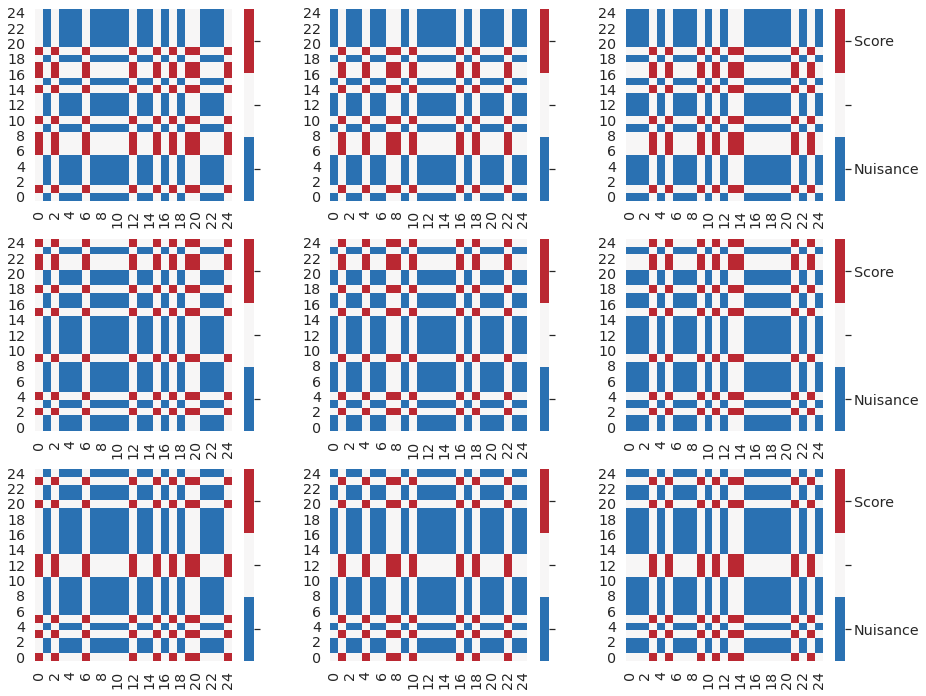

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



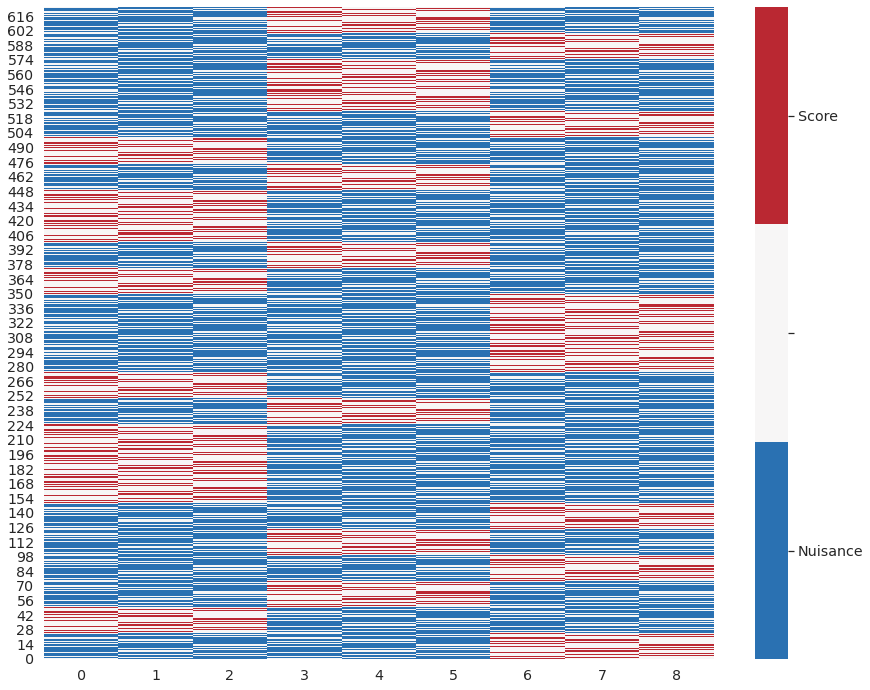

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])